In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [38]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        # initilize array with values epsilon/nA 
        actions = np.full(nA, epsilon/nA)
        # select action with the highest Q value
        best_action = np.argmax(Q[observation])
        # assing the bulk of probability to best action
        actions[best_action] += 1 - epsilon 
        return actions
    return policy_fn

In [119]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for ep in range(num_episodes):
        sequence = []
        observation = env.reset()
        # generate a sequence
        for t in range(100):
            # all possible actions
            actions = policy(observation)
            # select an action e-greedily 
            e_action = np.random.choice(np.arange(len(actions)), p = actions)
            next_observation, reward, done, _ = env.step(e_action)
            sequence.append((observation, e_action, reward))
            if done:
                break
            observation = next_observation
            
        G = 0
        # go through each step of the episode
        for step in range(len(sequence)-1, -1, -1):
            state = sequence[step][0]
            action = sequence[step][1]
            reward = sequence[step][2]
            action_state = state, action
            G = discount_factor * G + reward
            # a set of preceeding action states
            previous_states = {(s[0],s[1]) for s in sequence[:step]}
            # assert the state is visited only once
            if action_state not in previous_states:
                # update Q values
                returns_sum[action_state] += G
                returns_count[action_state] += 1
                Q[state][action] = returns_sum[action_state] / returns_count[action_state]
                
    return Q, policy

In [120]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

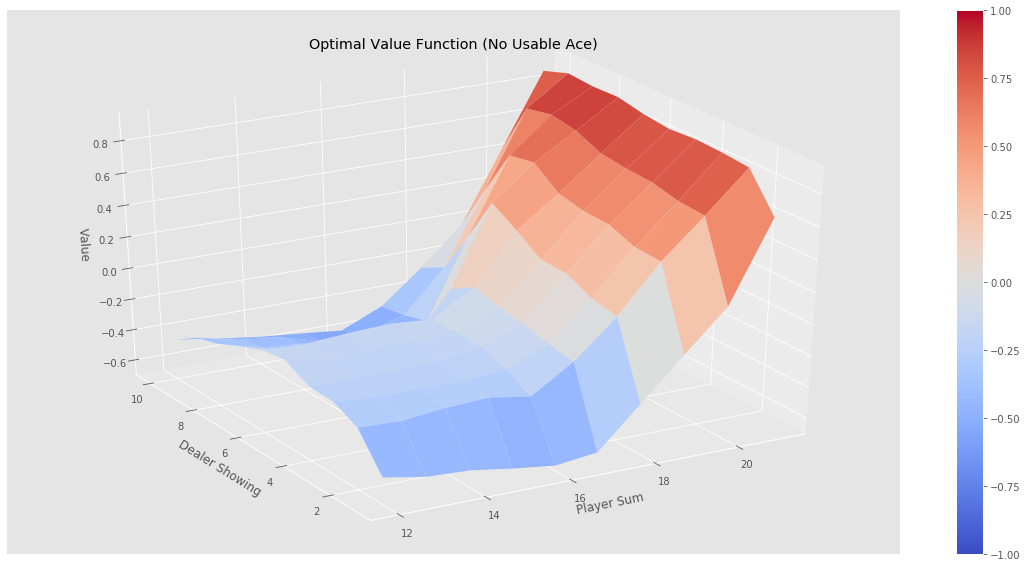

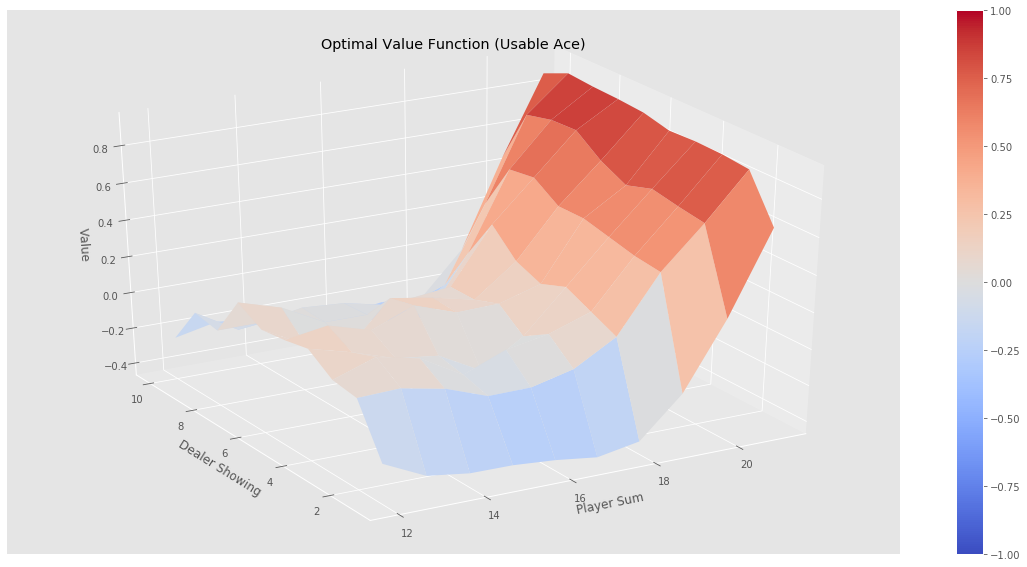

In [121]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")